In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [2]:
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

torch.device("cuda")

device(type='cuda')

In [3]:
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

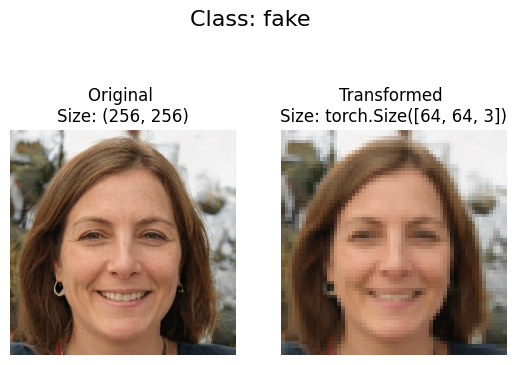

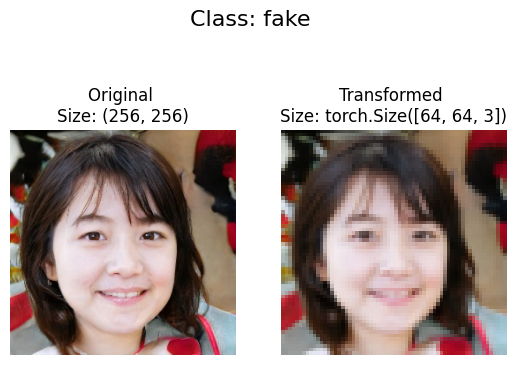

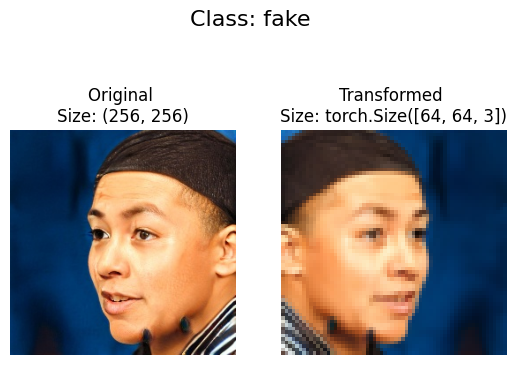

In [4]:
import random
from PIL import Image
from pathlib import Path


random.seed(42)

data_path = Path("RealvsFake_Face/")
image_path = data_path / "rvf10k"
train_dir = image_path / "train"
test_dir = image_path / "valid"
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_transformed_images(image_paths, transform, n=5, seed=11):
    seed = random.randint(1,100)
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [5]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [6]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [7]:
train_data.class_to_idx

{'fake': 0, 'real': 1}

In [8]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix,classification_report

# def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# def test_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     all_labels = []
#     all_predictions = []
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(test_loader):
#             inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())
                
#     print('\nAccuracy on the test set: %d %%' % (100 * correct / total))
#     report = classification_report(all_labels, all_predictions, digits=4)
#     print("Classification Report:")
#     print(report)

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    losses = []  # List to store loss values for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    
    # Plotting using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs + 1), y=losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()



def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    print('\nAccuracy on the test set: %d %%' % accuracy)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Compute classification report
    report = classification_report(all_labels, all_predictions, digits=4)
    print("Classification Report:")
    print(report)

def test_model2(model, test_loader, num_examples=5):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, digits=4)
    
    # Plotting accuracy
    plt.figure(figsize=(8, 6))
    plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
    plt.title('Accuracy on the test set')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.show()
    
    print('Accuracy on the test set: %.2f %%' % accuracy)
    print("Classification Report:")
    print(report)
    
    # Example predictions
    print("\nExample Predictions:")
    for i in range(num_examples):
        example_input, example_label = next(iter(test_loader))
        example_input = example_input[0].unsqueeze(0).to(torch.device('cuda'))
        example_output = model(example_input)
        _, example_prediction = torch.max(example_output.data, 1)
        
        # Display example input as an image
        plt.figure()
        plt.imshow(example_input.cpu().numpy().squeeze().transpose(1, 2, 0))  # Assuming input is in NCHW format
        plt.title("Example Input")
        plt.axis('off')
        plt.show()
        
        t = example_prediction.item()
        if t==1:
            t = "Real"
        else:
            t = "Fake"
        print("Predicted Label:", t)
        print()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Epoch 1/15, Loss: 0.7010743401267312
Epoch 2/15, Loss: 0.5874652155420997
Epoch 3/15, Loss: 0.5042554259300231
Epoch 4/15, Loss: 0.4553152314641259
Epoch 5/15, Loss: 0.3858520652760159
Epoch 6/15, Loss: 0.34055099907246505
Epoch 7/15, Loss: 0.267373836311427
Epoch 8/15, Loss: 0.20377518924122506
Epoch 9/15, Loss: 0.1762411542236805
Epoch 10/15, Loss: 0.1425969669764692
Epoch 11/15, Loss: 0.12362760041247714
Epoch 12/15, Loss: 0.10344973618841984
Epoch 13/15, Loss: 0.07974446460773998
Epoch 14/15, Loss: 0.07192839754914696
Epoch 15/15, Loss: 0.07532968621447005


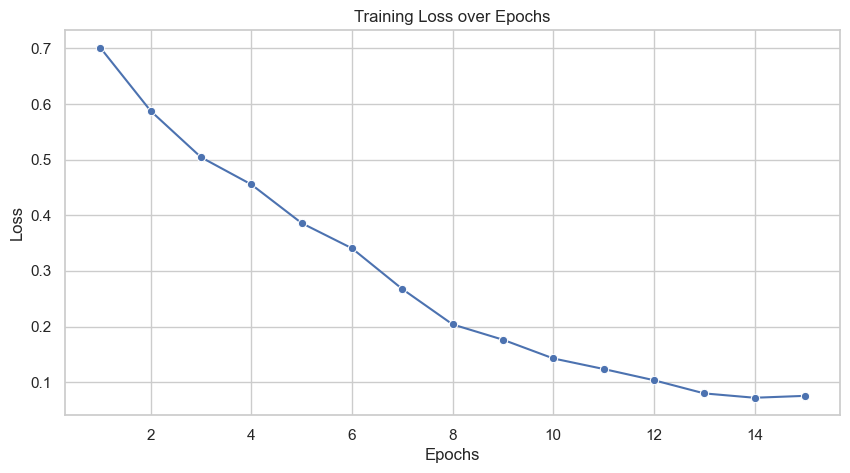


Accuracy on the test set: 84 %


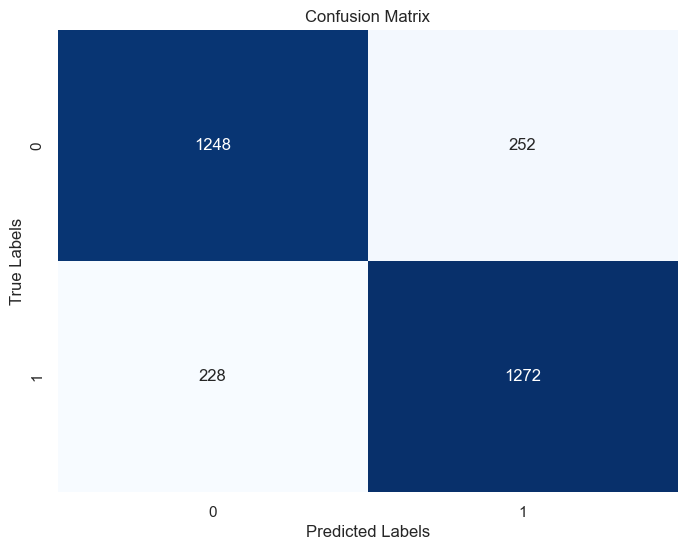

Classification Report:
              precision    recall  f1-score   support

           0     0.8455    0.8320    0.8387      1500
           1     0.8346    0.8480    0.8413      1500

    accuracy                         0.8400      3000
   macro avg     0.8401    0.8400    0.8400      3000
weighted avg     0.8401    0.8400    0.8400      3000



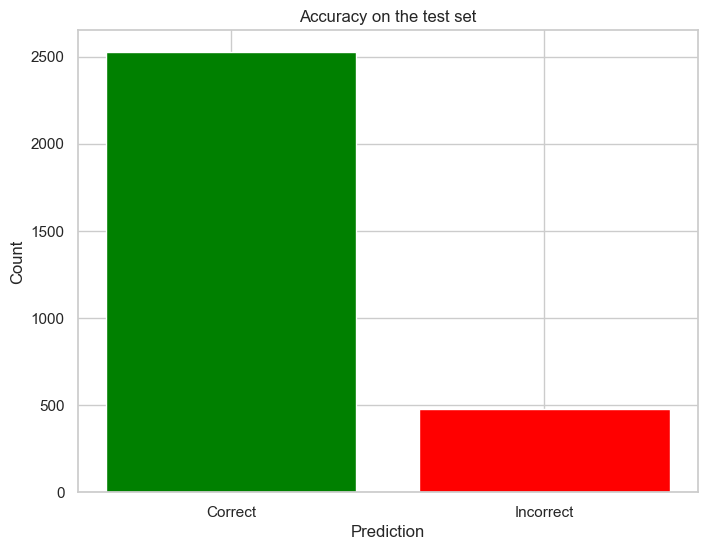

Accuracy on the test set: 84.17 %
Classification Report:
              precision    recall  f1-score   support

           0     0.8419    0.8413    0.8416      1500
           1     0.8414    0.8420    0.8417      1500

    accuracy                         0.8417      3000
   macro avg     0.8417    0.8417    0.8417      3000
weighted avg     0.8417    0.8417    0.8417      3000


Example Predictions:


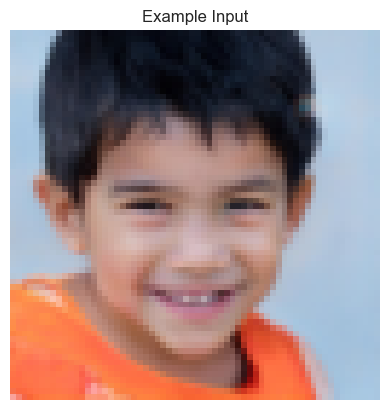

Predicted Label: Fake



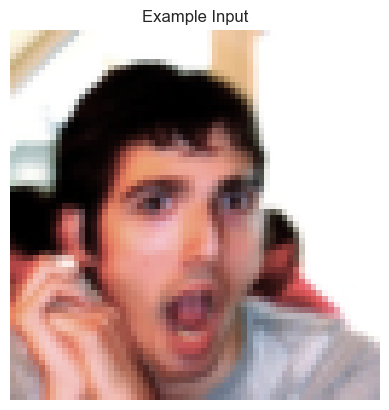

Predicted Label: Real



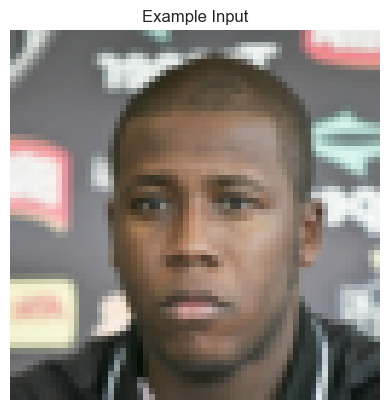

Predicted Label: Real



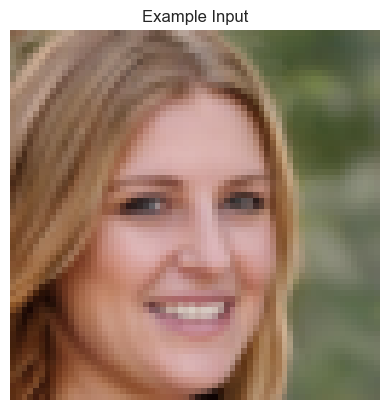

Predicted Label: Fake



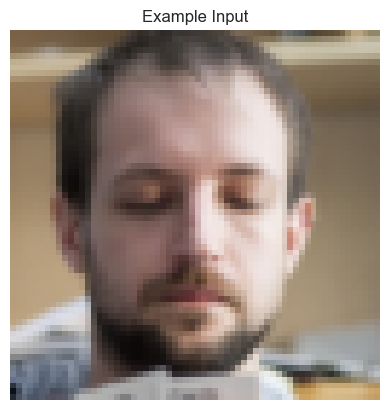

Predicted Label: Real



In [15]:
model3 = VGG16()
model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model3,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model3,test_dataloader)
test_model2(model3,test_dataloader)

In [11]:
# import torchvision
# import os

# # Get the version of Torch
# torch_version = torchvision.__version__

# # Get the path where torch is installed
# torch_path = os.path.dirname(torchvision.__file__)

# # Calculate the size of the torch directory
# torch_size = sum(os.path.getsize(os.path.join(root, file))
#                  for root, _, files in os.walk(torch_path)
#                  for file in files)

# # Convert bytes to megabytes for readability
# torch_size_mb = torch_size / (1024 * 1024)

# print(f"The Torch package (version {torch_version}) occupies approximately {torch_size_mb:.2f} megabytes.")


In [12]:
# torch.save(model3.state_dict(),"VGG16.pth")

In [13]:
# model = VGG16()
# model.load_state_dict(torch.load("VGG16.pth"))
# model.eval()
# test_model(model,test_dataloader)